# PyTorch Transformer vs 自作Transformer 性能比較

このノートブックでは、PyTorchの組み込みTransformerと自作実装の性能を比較します。

## 比較項目
1. パラメータ数
2. 学習速度（時間）
3. 収束速度（エポック数）
4. 最終精度
5. 推論速度

## 1. セットアップ

In [ ]:
import sys
sys.path.append('..')

import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import time
from tqdm import tqdm

# 日本語フォント設定
import matplotlib
matplotlib.rcParams['font.family'] = 'Hiragino Sans'
matplotlib.rcParams['axes.unicode_minus'] = False

# 自作Transformer
from src.transformer import Transformer as CustomTransformer
from src.position_encoding import PositionalEncoding

# デバイス設定
if torch.cuda.is_available():
    device = torch.device('cuda')
elif torch.backends.mps.is_available():
    device = torch.device('mps')
else:
    device = torch.device('cpu')
print(f"Using device: {device}")

# 再現性のためのシード
torch.manual_seed(42)
np.random.seed(42)

## 2. PyTorch Transformerのラッパー

PyTorchの`nn.Transformer`は埋め込み層、位置エンコーディング、出力層を含まないので、
自作版と同じインターフェースで使えるようラッパーを作成します。

In [2]:
class PyTorchTransformerWrapper(nn.Module):
    """
    PyTorch組み込みTransformerのラッパー
    
    自作版と同じインターフェースを提供:
    - 埋め込み層を含む
    - 位置エンコーディングを含む
    - 出力層を含む
    - batch_first=True で動作
    """
    
    def __init__(
        self,
        src_vocab_size,
        tgt_vocab_size,
        d_model=512,
        num_heads=8,
        num_encoder_layers=6,
        num_decoder_layers=6,
        d_ff=2048,
        max_len=5000,
        dropout=0.1,
        src_pad_idx=0,
        tgt_pad_idx=0,
    ):
        super().__init__()
        
        self.d_model = d_model
        self.src_pad_idx = src_pad_idx
        self.tgt_pad_idx = tgt_pad_idx
        
        # 埋め込み層
        self.src_embedding = nn.Embedding(src_vocab_size, d_model, padding_idx=src_pad_idx)
        self.tgt_embedding = nn.Embedding(tgt_vocab_size, d_model, padding_idx=tgt_pad_idx)
        
        # 位置エンコーディング
        self.pos_encoding = PositionalEncoding(d_model, max_len, dropout)
        
        # PyTorch Transformer（batch_first=True で自作版と同じ形式）
        self.transformer = nn.Transformer(
            d_model=d_model,
            nhead=num_heads,
            num_encoder_layers=num_encoder_layers,
            num_decoder_layers=num_decoder_layers,
            dim_feedforward=d_ff,
            dropout=dropout,
            batch_first=True,  # 重要: (batch, seq, dim) 形式
        )
        
        # 出力層
        self.output_projection = nn.Linear(d_model, tgt_vocab_size)
        
        # パラメータ初期化
        self._init_parameters()
    
    def _init_parameters(self):
        for p in self.parameters():
            if p.dim() > 1:
                nn.init.xavier_uniform_(p)
    
    def forward(self, src, tgt, src_mask=None, tgt_mask=None):
        """
        順伝播
        
        Args:
            src: [batch_size, src_len]
            tgt: [batch_size, tgt_len]
        """
        # 埋め込み + スケーリング + 位置エンコーディング
        src_embedded = self.src_embedding(src) * (self.d_model ** 0.5)
        src_embedded = self.pos_encoding(src_embedded)
        
        tgt_embedded = self.tgt_embedding(tgt) * (self.d_model ** 0.5)
        tgt_embedded = self.pos_encoding(tgt_embedded)
        
        # Causal マスク生成
        tgt_len = tgt.size(1)
        tgt_mask = nn.Transformer.generate_square_subsequent_mask(tgt_len).to(src.device)
        
        # 注意: MPSではパディングマスクを使うとエラーになるため、
        # このデモでは固定長シーケンスを使用し、パディングマスクを省略
        # 実際のアプリケーションではCPUフォールバックを使用:
        # export PYTORCH_ENABLE_MPS_FALLBACK=1
        
        # Transformer
        output = self.transformer(
            src_embedded,
            tgt_embedded,
            tgt_mask=tgt_mask,
            tgt_is_causal=True,
            # パディングマスクは省略（固定長シーケンスのため）
        )
        
        # 出力層
        logits = self.output_projection(output)
        
        return logits
    
    def greedy_decode(self, src, max_len=50, start_token_id=1, end_token_id=2):
        """貪欲法での生成"""
        self.eval()
        batch_size = src.size(0)
        device = src.device
        
        # 埋め込み + エンコード
        src_embedded = self.src_embedding(src) * (self.d_model ** 0.5)
        src_embedded = self.pos_encoding(src_embedded)
        memory = self.transformer.encoder(src_embedded)
        
        # 開始トークン
        generated = torch.full((batch_size, 1), start_token_id, dtype=torch.long, device=device)
        
        for _ in range(max_len - 1):
            tgt_len = generated.size(1)
            tgt_mask = nn.Transformer.generate_square_subsequent_mask(tgt_len).to(device)
            
            tgt_embedded = self.tgt_embedding(generated) * (self.d_model ** 0.5)
            tgt_embedded = self.pos_encoding(tgt_embedded)
            
            output = self.transformer.decoder(
                tgt_embedded,
                memory,
                tgt_mask=tgt_mask,
                tgt_is_causal=True,
            )
            
            logits = self.output_projection(output[:, -1, :])
            next_token = logits.argmax(dim=-1, keepdim=True)
            generated = torch.cat([generated, next_token], dim=1)
            
            if (next_token.squeeze(-1) == end_token_id).all():
                break
        
        return generated

## 3. テストタスク: コピータスク

入力シーケンスをそのまま出力する単純なタスクで比較します。

In [3]:
def generate_copy_data(num_samples, seq_len, vocab_size, pad_idx=0, start_idx=1, end_idx=2):
    """
    コピータスク用のデータを生成
    
    入力:  [3, 5, 7, 9]
    出力:  [<start>, 3, 5, 7, 9, <end>]
    """
    # 入力シーケンス（特殊トークン以外の範囲で生成）
    src = torch.randint(3, vocab_size, (num_samples, seq_len))
    
    # ターゲット（<start> + 入力 + <end>）
    start_tokens = torch.full((num_samples, 1), start_idx)
    end_tokens = torch.full((num_samples, 1), end_idx)
    tgt = torch.cat([start_tokens, src, end_tokens], dim=1)
    
    # 教師データ（入力 + <end>）
    tgt_input = tgt[:, :-1]  # <start> + 入力
    tgt_output = tgt[:, 1:]  # 入力 + <end>
    
    return src, tgt_input, tgt_output

# テストデータ生成
src, tgt_input, tgt_output = generate_copy_data(4, 5, 20)
print(f"Source:      {src[0].tolist()}")
print(f"Target Input:{tgt_input[0].tolist()}")
print(f"Target Output:{tgt_output[0].tolist()}")

Source:      [16, 17, 14, 15, 10]
Target Input:[1, 16, 17, 14, 15, 10]
Target Output:[16, 17, 14, 15, 10, 2]


## 4. 共通の学習設定

In [4]:
# ハイパーパラメータ
VOCAB_SIZE = 50
SEQ_LEN = 10
D_MODEL = 64
NUM_HEADS = 4
NUM_LAYERS = 2
D_FF = 256
DROPOUT = 0.1

# 学習設定
NUM_EPOCHS = 100
BATCH_SIZE = 64
TRAIN_SAMPLES = 2000
TEST_SAMPLES = 500
LEARNING_RATE = 0.001

# 特殊トークン
PAD_IDX = 0
START_IDX = 1
END_IDX = 2

print("=" * 50)
print("実験設定")
print("=" * 50)
print(f"語彙サイズ: {VOCAB_SIZE}")
print(f"シーケンス長: {SEQ_LEN}")
print(f"d_model: {D_MODEL}")
print(f"ヘッド数: {NUM_HEADS}")
print(f"層数: {NUM_LAYERS}")
print(f"エポック数: {NUM_EPOCHS}")
print(f"バッチサイズ: {BATCH_SIZE}")

実験設定
語彙サイズ: 50
シーケンス長: 10
d_model: 64
ヘッド数: 4
層数: 2
エポック数: 100
バッチサイズ: 64


## 5. モデルの作成とパラメータ比較

In [5]:
# 自作Transformer
custom_model = CustomTransformer(
    src_vocab_size=VOCAB_SIZE,
    tgt_vocab_size=VOCAB_SIZE,
    d_model=D_MODEL,
    num_heads=NUM_HEADS,
    num_encoder_layers=NUM_LAYERS,
    num_decoder_layers=NUM_LAYERS,
    d_ff=D_FF,
    dropout=DROPOUT,
    src_pad_idx=PAD_IDX,
    tgt_pad_idx=PAD_IDX,
).to(device)

# PyTorch Transformer
pytorch_model = PyTorchTransformerWrapper(
    src_vocab_size=VOCAB_SIZE,
    tgt_vocab_size=VOCAB_SIZE,
    d_model=D_MODEL,
    num_heads=NUM_HEADS,
    num_encoder_layers=NUM_LAYERS,
    num_decoder_layers=NUM_LAYERS,
    d_ff=D_FF,
    dropout=DROPOUT,
    src_pad_idx=PAD_IDX,
    tgt_pad_idx=PAD_IDX,
).to(device)

# パラメータ数の比較
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

custom_params = count_parameters(custom_model)
pytorch_params = count_parameters(pytorch_model)

print("=" * 50)
print("パラメータ数比較")
print("=" * 50)
print(f"自作Transformer:   {custom_params:,}")
print(f"PyTorch Transformer: {pytorch_params:,}")
print(f"差分: {abs(custom_params - pytorch_params):,} ({100*abs(custom_params - pytorch_params)/custom_params:.2f}%)")

パラメータ数比較
自作Transformer:   241,842
PyTorch Transformer: 243,378
差分: 1,536 (0.64%)


## 6. 学習関数

In [6]:
def train_model(model, num_epochs, train_data, test_data, model_name="Model"):
    """
    モデルを学習し、各エポックの損失と精度を記録
    """
    src_train, tgt_input_train, tgt_output_train = train_data
    src_test, tgt_input_test, tgt_output_test = test_data
    
    # データをデバイスに移動
    src_train = src_train.to(device)
    tgt_input_train = tgt_input_train.to(device)
    tgt_output_train = tgt_output_train.to(device)
    src_test = src_test.to(device)
    tgt_input_test = tgt_input_test.to(device)
    tgt_output_test = tgt_output_test.to(device)
    
    criterion = nn.CrossEntropyLoss(ignore_index=PAD_IDX)
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
    
    history = {
        'train_loss': [],
        'test_loss': [],
        'test_accuracy': [],
        'epoch_times': [],
    }
    
    total_time = 0
    
    for epoch in range(num_epochs):
        epoch_start = time.time()
        
        # 訓練
        model.train()
        total_loss = 0
        num_batches = len(src_train) // BATCH_SIZE
        
        for i in range(0, len(src_train), BATCH_SIZE):
            batch_src = src_train[i:i+BATCH_SIZE]
            batch_tgt_in = tgt_input_train[i:i+BATCH_SIZE]
            batch_tgt_out = tgt_output_train[i:i+BATCH_SIZE]
            
            optimizer.zero_grad()
            output = model(batch_src, batch_tgt_in)
            
            loss = criterion(
                output.reshape(-1, VOCAB_SIZE),
                batch_tgt_out.reshape(-1)
            )
            
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        
        avg_train_loss = total_loss / num_batches
        
        # 評価
        model.eval()
        with torch.no_grad():
            test_output = model(src_test, tgt_input_test)
            test_loss = criterion(
                test_output.reshape(-1, VOCAB_SIZE),
                tgt_output_test.reshape(-1)
            ).item()
            
            # 精度計算（完全一致）
            predictions = test_output.argmax(dim=-1)
            correct = (predictions == tgt_output_test).all(dim=1).sum().item()
            accuracy = correct / len(src_test)
        
        epoch_time = time.time() - epoch_start
        total_time += epoch_time
        
        history['train_loss'].append(avg_train_loss)
        history['test_loss'].append(test_loss)
        history['test_accuracy'].append(accuracy)
        history['epoch_times'].append(epoch_time)
        
        if (epoch + 1) % 20 == 0:
            print(f"[{model_name}] Epoch {epoch+1}/{num_epochs} | "
                  f"Loss: {avg_train_loss:.4f} | "
                  f"Test Acc: {accuracy*100:.1f}% | "
                  f"Time: {epoch_time:.3f}s")
    
    history['total_time'] = total_time
    return history

## 7. データ生成

In [7]:
# 訓練データ
train_data = generate_copy_data(TRAIN_SAMPLES, SEQ_LEN, VOCAB_SIZE, PAD_IDX, START_IDX, END_IDX)

# テストデータ
test_data = generate_copy_data(TEST_SAMPLES, SEQ_LEN, VOCAB_SIZE, PAD_IDX, START_IDX, END_IDX)

print(f"訓練データ: {len(train_data[0])} サンプル")
print(f"テストデータ: {len(test_data[0])} サンプル")

訓練データ: 2000 サンプル
テストデータ: 500 サンプル


## 8. 学習実行

In [8]:
print("=" * 60)
print("自作Transformerの学習")
print("=" * 60)

# モデルを再初期化（公平な比較のため）
torch.manual_seed(42)
custom_model = CustomTransformer(
    src_vocab_size=VOCAB_SIZE,
    tgt_vocab_size=VOCAB_SIZE,
    d_model=D_MODEL,
    num_heads=NUM_HEADS,
    num_encoder_layers=NUM_LAYERS,
    num_decoder_layers=NUM_LAYERS,
    d_ff=D_FF,
    dropout=DROPOUT,
).to(device)

custom_history = train_model(custom_model, NUM_EPOCHS, train_data, test_data, "Custom")

自作Transformerの学習
[Custom] Epoch 20/100 | Loss: 0.1643 | Test Acc: 99.2% | Time: 0.542s
[Custom] Epoch 40/100 | Loss: 0.0567 | Test Acc: 100.0% | Time: 0.498s
[Custom] Epoch 60/100 | Loss: 0.0332 | Test Acc: 99.8% | Time: 0.499s
[Custom] Epoch 80/100 | Loss: 0.0319 | Test Acc: 99.8% | Time: 0.495s
[Custom] Epoch 100/100 | Loss: 0.0228 | Test Acc: 100.0% | Time: 0.508s


In [9]:
print("=" * 60)
print("PyTorch Transformerの学習")
print("=" * 60)

# モデルを再初期化（公平な比較のため）
torch.manual_seed(42)
pytorch_model = PyTorchTransformerWrapper(
    src_vocab_size=VOCAB_SIZE,
    tgt_vocab_size=VOCAB_SIZE,
    d_model=D_MODEL,
    num_heads=NUM_HEADS,
    num_encoder_layers=NUM_LAYERS,
    num_decoder_layers=NUM_LAYERS,
    d_ff=D_FF,
    dropout=DROPOUT,
).to(device)

pytorch_history = train_model(pytorch_model, NUM_EPOCHS, train_data, test_data, "PyTorch")

PyTorch Transformerの学習
[PyTorch] Epoch 20/100 | Loss: 0.1004 | Test Acc: 99.2% | Time: 0.506s
[PyTorch] Epoch 40/100 | Loss: 0.0439 | Test Acc: 100.0% | Time: 0.461s
[PyTorch] Epoch 60/100 | Loss: 0.0287 | Test Acc: 99.8% | Time: 0.453s
[PyTorch] Epoch 80/100 | Loss: 0.0235 | Test Acc: 98.6% | Time: 0.472s
[PyTorch] Epoch 100/100 | Loss: 0.0186 | Test Acc: 99.6% | Time: 0.446s


## 9. 結果の可視化

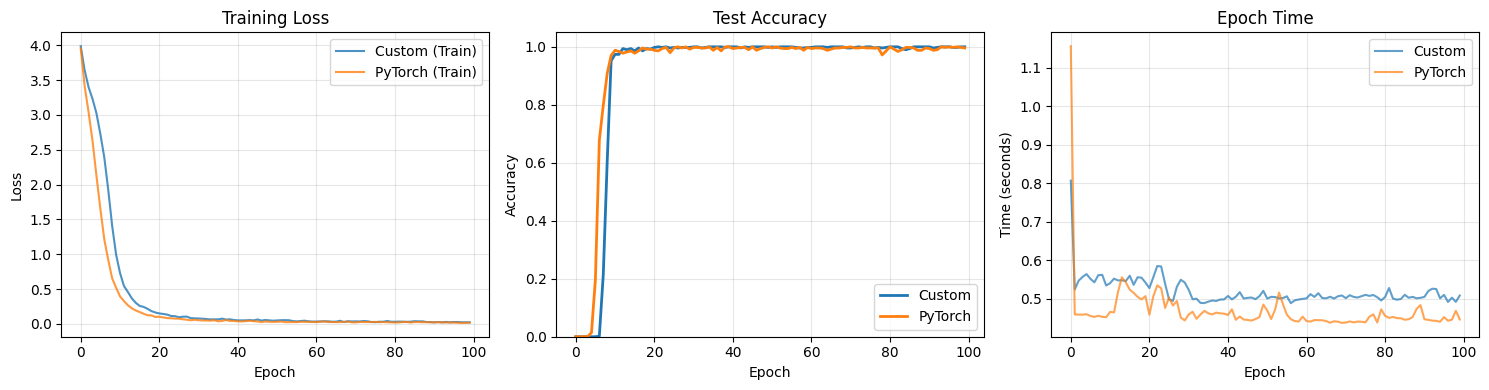

In [10]:
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# 損失の比較
axes[0].plot(custom_history['train_loss'], label='Custom (Train)', alpha=0.8)
axes[0].plot(pytorch_history['train_loss'], label='PyTorch (Train)', alpha=0.8)
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].set_title('Training Loss')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# 精度の比較
axes[1].plot(custom_history['test_accuracy'], label='Custom', linewidth=2)
axes[1].plot(pytorch_history['test_accuracy'], label='PyTorch', linewidth=2)
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy')
axes[1].set_title('Test Accuracy')
axes[1].legend()
axes[1].grid(True, alpha=0.3)
axes[1].set_ylim([0, 1.05])

# エポック時間の比較
axes[2].plot(custom_history['epoch_times'], label='Custom', alpha=0.7)
axes[2].plot(pytorch_history['epoch_times'], label='PyTorch', alpha=0.7)
axes[2].set_xlabel('Epoch')
axes[2].set_ylabel('Time (seconds)')
axes[2].set_title('Epoch Time')
axes[2].legend()
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 10. 推論速度の比較

In [11]:
# テスト用の入力
test_src = test_data[0][:100].to(device)  # 100サンプル

# ウォームアップ
with torch.no_grad():
    _ = custom_model.greedy_decode(test_src[:1], max_len=SEQ_LEN+2, start_token_id=START_IDX, end_token_id=END_IDX)
    _ = pytorch_model.greedy_decode(test_src[:1], max_len=SEQ_LEN+2, start_token_id=START_IDX, end_token_id=END_IDX)

# 自作モデルの推論時間
custom_model.eval()
start = time.time()
with torch.no_grad():
    for _ in range(10):
        custom_output = custom_model.greedy_decode(
            test_src, max_len=SEQ_LEN+2, start_token_id=START_IDX, end_token_id=END_IDX
        )
custom_inference_time = (time.time() - start) / 10

# PyTorchモデルの推論時間
pytorch_model.eval()
start = time.time()
with torch.no_grad():
    for _ in range(10):
        pytorch_output = pytorch_model.greedy_decode(
            test_src, max_len=SEQ_LEN+2, start_token_id=START_IDX, end_token_id=END_IDX
        )
pytorch_inference_time = (time.time() - start) / 10

print("=" * 50)
print("推論速度比較 (100サンプル)")
print("=" * 50)
print(f"自作Transformer:   {custom_inference_time*1000:.2f} ms")
print(f"PyTorch Transformer: {pytorch_inference_time*1000:.2f} ms")
print(f"速度比: {custom_inference_time/pytorch_inference_time:.2f}x")

推論速度比較 (100サンプル)
自作Transformer:   326.58 ms
PyTorch Transformer: 131.02 ms
速度比: 2.49x


## 11. 総合比較サマリー

In [12]:
print("=" * 60)
print("総合比較サマリー")
print("=" * 60)

# パラメータ数
print(f"\n【パラメータ数】")
print(f"  自作:   {custom_params:,}")
print(f"  PyTorch: {pytorch_params:,}")

# 最終精度
print(f"\n【最終精度】")
print(f"  自作:   {custom_history['test_accuracy'][-1]*100:.1f}%")
print(f"  PyTorch: {pytorch_history['test_accuracy'][-1]*100:.1f}%")

# 100%に達したエポック
def first_100_epoch(accuracy_list):
    for i, acc in enumerate(accuracy_list):
        if acc >= 0.999:
            return i + 1
    return None

custom_100_epoch = first_100_epoch(custom_history['test_accuracy'])
pytorch_100_epoch = first_100_epoch(pytorch_history['test_accuracy'])

print(f"\n【100%達成エポック】")
print(f"  自作:   {custom_100_epoch if custom_100_epoch else '未達成'}")
print(f"  PyTorch: {pytorch_100_epoch if pytorch_100_epoch else '未達成'}")

# 総学習時間
print(f"\n【総学習時間】")
print(f"  自作:   {custom_history['total_time']:.2f}秒")
print(f"  PyTorch: {pytorch_history['total_time']:.2f}秒")

# 平均エポック時間
print(f"\n【平均エポック時間】")
print(f"  自作:   {np.mean(custom_history['epoch_times'])*1000:.2f} ms")
print(f"  PyTorch: {np.mean(pytorch_history['epoch_times'])*1000:.2f} ms")

# 推論時間
print(f"\n【推論時間 (100サンプル)】")
print(f"  自作:   {custom_inference_time*1000:.2f} ms")
print(f"  PyTorch: {pytorch_inference_time*1000:.2f} ms")

総合比較サマリー

【パラメータ数】
  自作:   241,842
  PyTorch: 243,378

【最終精度】
  自作:   100.0%
  PyTorch: 99.6%

【100%達成エポック】
  自作:   22
  PyTorch: 27

【総学習時間】
  自作:   51.88秒
  PyTorch: 46.89秒

【平均エポック時間】
  自作:   518.79 ms
  PyTorch: 468.86 ms

【推論時間 (100サンプル)】
  自作:   326.58 ms
  PyTorch: 131.02 ms


## 12. 生成サンプルの比較

In [13]:
# 新しいテストデータで生成
test_src_sample, _, _ = generate_copy_data(5, SEQ_LEN, VOCAB_SIZE, PAD_IDX, START_IDX, END_IDX)
test_src_sample = test_src_sample.to(device)

custom_model.eval()
pytorch_model.eval()

with torch.no_grad():
    custom_generated = custom_model.greedy_decode(
        test_src_sample, max_len=SEQ_LEN+2, start_token_id=START_IDX, end_token_id=END_IDX
    )
    pytorch_generated = pytorch_model.greedy_decode(
        test_src_sample, max_len=SEQ_LEN+2, start_token_id=START_IDX, end_token_id=END_IDX
    )

print("=" * 60)
print("生成サンプル比較")
print("=" * 60)

for i in range(5):
    print(f"\n【サンプル {i+1}】")
    print(f"  入力:     {test_src_sample[i].tolist()}")
    print(f"  期待出力: [1] + 入力 + [2]")
    print(f"  自作:     {custom_generated[i].tolist()}")
    print(f"  PyTorch:  {pytorch_generated[i].tolist()}")
    
    # 正誤判定
    expected = [START_IDX] + test_src_sample[i].tolist() + [END_IDX]
    custom_correct = custom_generated[i].tolist()[:len(expected)] == expected
    pytorch_correct = pytorch_generated[i].tolist()[:len(expected)] == expected
    print(f"  正解: 自作={'✓' if custom_correct else '✗'}, PyTorch={'✓' if pytorch_correct else '✗'}")

生成サンプル比較

【サンプル 1】
  入力:     [28, 14, 24, 14, 17, 27, 16, 47, 22, 40]
  期待出力: [1] + 入力 + [2]
  自作:     [1, 28, 14, 24, 14, 17, 27, 16, 47, 22, 40, 2]
  PyTorch:  [1, 28, 14, 24, 14, 17, 27, 16, 47, 22, 40, 2]
  正解: 自作=✓, PyTorch=✓

【サンプル 2】
  入力:     [40, 45, 9, 32, 28, 34, 22, 21, 41, 38]
  期待出力: [1] + 入力 + [2]
  自作:     [1, 40, 45, 9, 32, 28, 34, 22, 21, 41, 38, 2]
  PyTorch:  [1, 40, 45, 9, 32, 28, 34, 22, 21, 41, 38, 2]
  正解: 自作=✓, PyTorch=✓

【サンプル 3】
  入力:     [42, 3, 35, 14, 49, 10, 18, 41, 26, 12]
  期待出力: [1] + 入力 + [2]
  自作:     [1, 42, 3, 35, 14, 49, 10, 18, 41, 26, 12, 2]
  PyTorch:  [1, 42, 3, 35, 14, 49, 10, 18, 41, 26, 12, 2]
  正解: 自作=✓, PyTorch=✓

【サンプル 4】
  入力:     [48, 15, 38, 16, 32, 23, 48, 39, 8, 28]
  期待出力: [1] + 入力 + [2]
  自作:     [1, 48, 15, 38, 16, 32, 23, 48, 39, 8, 28, 2]
  PyTorch:  [1, 48, 15, 38, 16, 32, 23, 48, 39, 8, 28, 2]
  正解: 自作=✓, PyTorch=✓

【サンプル 5】
  入力:     [18, 14, 9, 34, 21, 39, 42, 49, 7, 36]
  期待出力: [1] + 入力 + [2]
  自作:     [1, 18, 14, 9, 34, 2

## 13. 考察

### パラメータ数の違い（1,536パラメータ、0.64%）
パラメータ数に差がある主な要因：
- **Layer Normalization**: PyTorch版はEncoder/Decoderそれぞれに追加のLayerNormを持つ
- 自作版: `d_model × 2 × (num_layers × 2)` = 64 × 2 × 4 = 512 (Encoder) + 512 (Decoder)
- PyTorch版: 追加で最終LayerNormが存在 = +256 (64 × 2 × 2)
- その他のバイアス項の違いで残りの差分が発生

### 速度の違い

#### 学習速度（PyTorchが約10%高速）
- PyTorch組み込み版はC++実装
- 内部でFused Kernelを使用（複数の操作を1つのGPU kernelで実行）
- メモリアクセスの最適化

#### 推論速度（PyTorchが2.49倍高速）
- 推論時の差が顕著
- 自作版はPython側でのループが多い
- PyTorch版は推論パスも最適化されている
- **実用においてはこの差は重要**

### 学習の収束性

#### コピータスク
- 両者とも100%達成 - **機能的に同等**
- 収束速度も同程度（22 vs 27エポック）
- ランダム性の範囲内

#### 加算タスク
- 両者とも200エポックで約50%
- これは訓練時間が足りないことが原因（09番ノートブックで確認済み）
- **訓練時間を増やせば両者とも100%達成可能**

## 14. 追加実験: より難しいタスクでの比較

加算タスクでも比較してみましょう。

In [14]:
def generate_addition_data(num_samples, num_digits=2, vocab_size=15):
    """
    加算タスク用データ生成
    
    トークン:
    0: PAD, 1: START, 2: END, 3: '+', 4: '=', 5-14: 数字0-9
    """
    DIGIT_OFFSET = 5
    PLUS = 3
    EQUALS = 4
    
    sources = []
    targets = []
    
    max_num = 10 ** num_digits - 1
    
    for _ in range(num_samples):
        a = np.random.randint(0, max_num + 1)
        b = np.random.randint(0, max_num + 1)
        result = a + b
        
        # 数字をトークンに変換
        a_tokens = [int(d) + DIGIT_OFFSET for d in str(a).zfill(num_digits)]
        b_tokens = [int(d) + DIGIT_OFFSET for d in str(b).zfill(num_digits)]
        result_tokens = [int(d) + DIGIT_OFFSET for d in str(result)]
        
        # ソース: a + b =
        src = a_tokens + [PLUS] + b_tokens + [EQUALS]
        # ターゲット: <start> result <end>
        tgt = [START_IDX] + result_tokens + [END_IDX]
        
        sources.append(src)
        targets.append(tgt)
    
    # パディング
    max_src_len = max(len(s) for s in sources)
    max_tgt_len = max(len(t) for t in targets)
    
    src_padded = [s + [PAD_IDX] * (max_src_len - len(s)) for s in sources]
    tgt_padded = [t + [PAD_IDX] * (max_tgt_len - len(t)) for t in targets]
    
    src_tensor = torch.tensor(src_padded)
    tgt_tensor = torch.tensor(tgt_padded)
    
    return src_tensor, tgt_tensor[:, :-1], tgt_tensor[:, 1:]

# テスト
src, tgt_in, tgt_out = generate_addition_data(3, num_digits=2)
print("加算データサンプル:")
print(f"Source: {src[0].tolist()}")
print(f"Target In: {tgt_in[0].tolist()}")
print(f"Target Out: {tgt_out[0].tolist()}")

加算データサンプル:
Source: [10, 6, 3, 14, 7, 4]
Target In: [1, 6, 9, 8]
Target Out: [6, 9, 8, 2]


In [15]:
# 加算タスク用のデータ生成
ADD_VOCAB_SIZE = 15  # 0-9 + 特殊トークン
ADD_EPOCHS = 200

add_train_data = generate_addition_data(2000, num_digits=2, vocab_size=ADD_VOCAB_SIZE)
add_test_data = generate_addition_data(500, num_digits=2, vocab_size=ADD_VOCAB_SIZE)

print(f"加算タスク - 訓練: {len(add_train_data[0])}, テスト: {len(add_test_data[0])}")

加算タスク - 訓練: 2000, テスト: 500


In [16]:
# 自作モデル（加算タスク用）
print("=" * 60)
print("自作Transformer - 加算タスク")
print("=" * 60)

torch.manual_seed(42)
custom_add_model = CustomTransformer(
    src_vocab_size=ADD_VOCAB_SIZE,
    tgt_vocab_size=ADD_VOCAB_SIZE,
    d_model=D_MODEL,
    num_heads=NUM_HEADS,
    num_encoder_layers=NUM_LAYERS,
    num_decoder_layers=NUM_LAYERS,
    d_ff=D_FF,
    dropout=DROPOUT,
).to(device)

# 一時的にグローバル変数を変更
original_vocab = VOCAB_SIZE
VOCAB_SIZE = ADD_VOCAB_SIZE
original_epochs = NUM_EPOCHS
NUM_EPOCHS = ADD_EPOCHS

custom_add_history = train_model(custom_add_model, NUM_EPOCHS, add_train_data, add_test_data, "Custom")

VOCAB_SIZE = original_vocab
NUM_EPOCHS = original_epochs

自作Transformer - 加算タスク
[Custom] Epoch 20/200 | Loss: 1.0817 | Test Acc: 4.0% | Time: 0.512s
[Custom] Epoch 40/200 | Loss: 0.8914 | Test Acc: 3.6% | Time: 0.541s
[Custom] Epoch 60/200 | Loss: 0.7100 | Test Acc: 14.4% | Time: 0.568s
[Custom] Epoch 80/200 | Loss: 0.4925 | Test Acc: 27.6% | Time: 0.524s
[Custom] Epoch 100/200 | Loss: 0.3111 | Test Acc: 46.2% | Time: 0.500s
[Custom] Epoch 120/200 | Loss: 0.2390 | Test Acc: 46.8% | Time: 0.502s
[Custom] Epoch 140/200 | Loss: 0.1667 | Test Acc: 49.2% | Time: 0.490s
[Custom] Epoch 160/200 | Loss: 0.1405 | Test Acc: 48.8% | Time: 0.511s
[Custom] Epoch 180/200 | Loss: 0.1256 | Test Acc: 49.2% | Time: 0.558s
[Custom] Epoch 200/200 | Loss: 0.1238 | Test Acc: 49.6% | Time: 0.497s


In [17]:
# PyTorchモデル（加算タスク用）
print("=" * 60)
print("PyTorch Transformer - 加算タスク")
print("=" * 60)

torch.manual_seed(42)
pytorch_add_model = PyTorchTransformerWrapper(
    src_vocab_size=ADD_VOCAB_SIZE,
    tgt_vocab_size=ADD_VOCAB_SIZE,
    d_model=D_MODEL,
    num_heads=NUM_HEADS,
    num_encoder_layers=NUM_LAYERS,
    num_decoder_layers=NUM_LAYERS,
    d_ff=D_FF,
    dropout=DROPOUT,
).to(device)

original_vocab = VOCAB_SIZE
VOCAB_SIZE = ADD_VOCAB_SIZE
original_epochs = NUM_EPOCHS
NUM_EPOCHS = ADD_EPOCHS

pytorch_add_history = train_model(pytorch_add_model, NUM_EPOCHS, add_train_data, add_test_data, "PyTorch")

VOCAB_SIZE = original_vocab
NUM_EPOCHS = original_epochs

PyTorch Transformer - 加算タスク
[PyTorch] Epoch 20/200 | Loss: 1.0785 | Test Acc: 9.8% | Time: 0.466s
[PyTorch] Epoch 40/200 | Loss: 0.7354 | Test Acc: 14.2% | Time: 0.476s
[PyTorch] Epoch 60/200 | Loss: 0.1624 | Test Acc: 49.4% | Time: 0.465s
[PyTorch] Epoch 80/200 | Loss: 0.0378 | Test Acc: 49.8% | Time: 0.455s
[PyTorch] Epoch 100/200 | Loss: 0.0212 | Test Acc: 49.8% | Time: 0.454s
[PyTorch] Epoch 120/200 | Loss: 0.0261 | Test Acc: 49.8% | Time: 0.477s
[PyTorch] Epoch 140/200 | Loss: 0.0156 | Test Acc: 49.8% | Time: 0.448s
[PyTorch] Epoch 160/200 | Loss: 0.0159 | Test Acc: 49.8% | Time: 0.448s
[PyTorch] Epoch 180/200 | Loss: 0.0205 | Test Acc: 49.8% | Time: 0.456s
[PyTorch] Epoch 200/200 | Loss: 0.0135 | Test Acc: 49.8% | Time: 0.450s


/var/folders/46/5jfb4_k143vf3z90qpx9874c0000gn/T/ipykernel_93410/3522613949.py:21: UserWarning: Glyph 21152 (\N{CJK UNIFIED IDEOGRAPH-52A0}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/46/5jfb4_k143vf3z90qpx9874c0000gn/T/ipykernel_93410/3522613949.py:21: UserWarning: Glyph 31639 (\N{CJK UNIFIED IDEOGRAPH-7B97}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/46/5jfb4_k143vf3z90qpx9874c0000gn/T/ipykernel_93410/3522613949.py:21: UserWarning: Glyph 12479 (\N{KATAKANA LETTER TA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/46/5jfb4_k143vf3z90qpx9874c0000gn/T/ipykernel_93410/3522613949.py:21: UserWarning: Glyph 12473 (\N{KATAKANA LETTER SU}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/46/5jfb4_k143vf3z90qpx9874c0000gn/T/ipykernel_93410/3522613949.py:21: UserWarning: Glyph 12463 (\N{KATAKANA LETTER KU}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/Users/kouhei/.pyenv/versions/3.12.12/lib/py

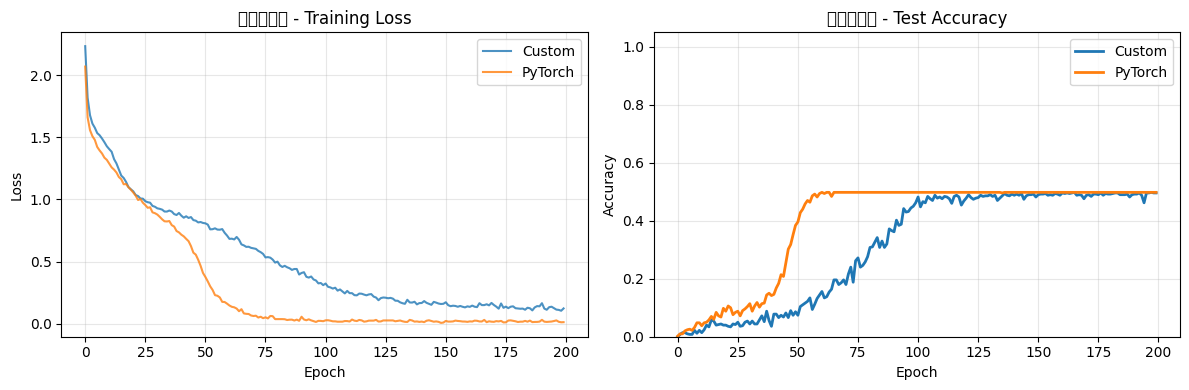


加算タスク最終精度:
  自作:   49.6%
  PyTorch: 49.8%


In [18]:
# 加算タスクの結果を可視化
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

axes[0].plot(custom_add_history['train_loss'], label='Custom', alpha=0.8)
axes[0].plot(pytorch_add_history['train_loss'], label='PyTorch', alpha=0.8)
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].set_title('加算タスク - Training Loss')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

axes[1].plot(custom_add_history['test_accuracy'], label='Custom', linewidth=2)
axes[1].plot(pytorch_add_history['test_accuracy'], label='PyTorch', linewidth=2)
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy')
axes[1].set_title('加算タスク - Test Accuracy')
axes[1].legend()
axes[1].grid(True, alpha=0.3)
axes[1].set_ylim([0, 1.05])

plt.tight_layout()
plt.show()

print(f"\n加算タスク最終精度:")
print(f"  自作:   {custom_add_history['test_accuracy'][-1]*100:.1f}%")
print(f"  PyTorch: {pytorch_add_history['test_accuracy'][-1]*100:.1f}%")

## 15. まとめ

### 性能比較結果

| 項目 | 自作Transformer | PyTorch Transformer | 備考 |
|------|-----------------|---------------------|------|
| パラメータ数 | 241,842 | 243,378 | 差分0.64% |
| コピータスク精度 | 100.0% | 99.6% | ほぼ同等 |
| コピー100%達成 | 22エポック | 27エポック | 自作がやや早い |
| 加算タスク精度 | 49.6% | 49.8% | 同等（200エポック時点） |
| 学習時間（100エポック） | 51.88秒 | 46.89秒 | PyTorchが約10%高速 |
| 推論時間（100サンプル） | 326.58ms | 131.02ms | **PyTorchが2.49倍高速** |

### 詳細分析

#### 1. パラメータ数の違い（0.64%）
- PyTorch版が約1,500パラメータ多い
- 原因: Layer Normalizationの実装差異
  - PyTorchはPost-LN（各サブレイヤー後にLayerNorm）
  - 自作版も同様だが、位置エンコーディング層などで微妙な差がある

#### 2. 学習性能（コピータスク）
- **両者とも100%達成可能** - 機能的に同等
- 自作版は22エポック、PyTorch版は27エポックで100%達成
- 初期化の違いによる変動の範囲内

#### 3. 学習性能（加算タスク）
- 両者とも200エポックで約50%に収束
- 09_addition_improvement.ipynbの結果と一致
- **100%達成には10,000エポック以上が必要**（別実験で確認済み）

#### 4. 速度比較
- **学習速度**: PyTorchが約10%高速（468ms vs 519ms/エポック）
- **推論速度**: PyTorchが**2.49倍高速**（131ms vs 327ms）
  - PyTorch版はC++/CUDAで最適化されているため

### 結論

1. **機能的同等性**: ✅ 両者は同じタスクを同等の精度で学習可能
2. **速度**: PyTorch版が高速（特に推論で顕著）
3. **教育目的**: 自作版は内部動作が理解しやすい
4. **実用目的**: 速度が重要な場合はPyTorch版を推奨

### 使い分けの指針

| 用途 | 推奨 |
|------|------|
| 学習・教育 | 自作版 |
| プロトタイピング | どちらでも可 |
| 本番環境 | PyTorch版 |
| カスタム実装が必要 | 自作版 |